In [2]:
import sys
print(sys.version)
print(sys.executable)

3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]
/Users/Guangyuan/opt/anaconda3/envs/r_keras/bin/python


# 目录
1. [环境设置](#started)
2. [导入数据](#import)
3. [数据预处理](#preprocess)
4. [描述性分析](#describe)
5. [Machine learning](#ML)  
    5.1. [Adaptive boosting (ADA)](#ADA)  
    .......5.1.1. [Bag-of-words](#ADA_BOW)  
    .......5.1.2. [Bag-of-POS](#ADA_BOP)  
    .......5.1.3. [Embeddings](#ADA_E)  
    5.2. [Random forests (RF)](#RF)  
    .......5.2.1. [Bag-of-words](#RF_BOW)  
    .......5.2.2. [Bag-of-POS](#RF_BOP)  
    .......5.2.3. [Embeddings](#RF_E)  
    5.3. [Extreme gradient boosting (XGB)](#XGB)  
    .......5.3.1. [Bag-of-words](#XGB_BOW)  
    .......5.3.2. [Bag-of-POS](#XGB_BOP)  
    .......5.3.3. [Embeddings](#XGB_E)
6. [Deep learning](#DL)  
    6.1. [Train test split](#trainsplit)  
    6.2. [Define the model](#modeldef)  
    .......6.2.1. [Shallow LSTM](#LSTM1)  
    .......6.2.2. [Shallow GRU](#GRU1)  
    .......6.2.3. [Deep LSTM](#LSTM2)    
    6.3. [Train the model](#trainmodel)  
    6.4. [Evaluate the model on test data](#evalmodel)  

# 1. 环境设置<a name="started"></a>

变量初始化和显示设置

In [3]:
# Notebook settings
###################
# resetting variables
get_ipython().magic('reset -sf') 
# formatting: cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# plotting
%matplotlib inline

# 2. 导入数据<a name="import"></a>

我们从原始数据（50000条评论数据，平均分为train/pos、train/neg、test/pos和test/neg四部分）中随机抽取了1%，即500条数据进行测试。
该部分将分布在四个文件夹中（保持原始文件结构不变）500条数据依次全部读取到DataFrame类型的df变量中。

In [4]:
def listdirInMac(path):
    os_list = os.listdir(path)
    for item in os_list:
        if item.startswith('.') and os.path.isfile(os.path.join(path, item)):
            os_list.remove(item)
    return os_list
#因为os.listdir会默认把隐藏文件读进去 所以对该函数进行重新定义 不然会报错
# we use the import function, as in Chapter 8 of Raschka's book (see the tutorial)
import pyprind
import pandas as pd
import os
basepath = './toymdb/' # insert basepath, where original data are stored

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(500)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in listdirInMac(path):
            #把原来的os.listdir改为listdirInMac
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [5]:
print(df.head(1))

                                              review  sentiment
0  I rented this obscure aussie relic a few years...          1


# 3. 数据预处理<a name="preprocess"></a>

该部分包括：<br><br/>
3.1 去重<br><br/>
3.2 随机排列<br><br/>
3.3 符号和大小写处理<br><br/>
3.4 生成针对模型的数据<br><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;3.4.1 词性标注<br><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;3.4.2 词嵌入<br><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;3.4.3 用Keras进行针对RNN模型的数据预处理<br><br/>
分别生成data_POStagged.csv、data_dedandprep.csv和movie_data_processed.csv三个数据文件，其中前两个文件用于ml模型，带三个文件用于RNN模型。

## 3.1 去重<a name="duplicated"></a>

In [6]:
# check for duplicates
duplicates = df[df.duplicated()]  #equivalent to keep = first. Duplicated rows, except the first entry, are marked as 'True'
print(len(duplicates))
#抽取的部分不存在重复数据

0


In [7]:
# remove duplicates: 
df = df.drop_duplicates()
df.shape
#总共抽取了train和test中pos和neg各125个数据 总计500个

(500, 2)

In [8]:
# double check
df[df.duplicated(subset='review')]

,review,sentiment


## 3.2 随机化<a name="Shuffle"></a>

因为读取的时候是按照train/pos、train/neg、test/pos和test/neg顺序读取的，有模型训练时，我们采用前80%作为训练数据，后20%作为预测数据，如果不做随机处理，预测数据的实际类型都是一致的。（实际上在ml模型拟合之前都重新对数据进行了随机化，所以这一步是针对DL模型的）

In [9]:
# We shuffle the data to ensure randomness in the training input
# 随机排列
import numpy as np
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

## 3.3 符号和大小写处理<a name="mark"></a>

In [10]:
# an example of 'raw' review: we have all sort of HTML markup
df.loc[2, 'review']

"This movie is the only movie to feature a scene in which Michael Jackson wields a Tommy Gun. Plain and simple.<br /><br />This movie rocks because it is freaking' hilarious! It may be creepy to see Jacko w/ little kids, but this movie also stars.......................................... wait for it,.....................<br /><br />JOE PESCI!!!!!!!!!!!!!!!!!!!!!<br /><br />Think about it, Joe Pesci and Jacko with Tommy guns, throwing coins into jukeboxes from 20 feet away? Whats not to like? As stated before, THIS MOVIE ROCKS!!!!!!!!!!!! !!!!!!! !!!!!!!!!!! !!!!!!!! !!!! !!!!!!! !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! !!!!!!!!!!!!!! !!!!!!!!!! !!!!!!! ! !!!! !!!!!!!!!!!!!!!!!!!!!!"

In [11]:
# preprocessing by Raschka, Chpater 8 (see tutorial)
# we remove all markups, substitute non-alphanumeric characters (including 
# underscore) with whitespaces, and remove the nose from emoticons
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    #sub() 替换函数
    #用’‘替换 <[^>]*> 这些字符
    #即将 <[^>]*> 这些字符都删去
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # ?: 匹配但不获取结果 要和其他的模式一起使用
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

df['review'] = df['review'].apply(preprocessor)

In [12]:
df.loc[2, 'review']

'this movie is the only movie to feature a scene in which michael jackson wields a tommy gun plain and simple this movie rocks because it is freaking hilarious it may be creepy to see jacko w little kids but this movie also stars wait for it joe pesci think about it joe pesci and jacko with tommy guns throwing coins into jukeboxes from 20 feet away whats not to like as stated before this movie rocks '

In [13]:
# save preprocessed data as csv 
path = './toymdb/data_preprocessed.csv'  # insert path
df.to_csv(path, index=False, encoding='utf-8')

## 3.4 生成针对模型的数据<a name="preprocess2model"></a>

需要注意的是，这一步生成的数据并不是最终进行模型拟合的数据。

### 3.4.1 词性标准<a name="POS-tagging"></a>

该步骤的目的是为每一条文本生成'text_pos'属性，该属性是一个由“-”连接的字符串，它按顺序连接了经过预处理的文本中每个单词的词性数据。

In [14]:
# we apply POS-tagging on (deduplicated and) pre-processed data - let us import them
path = './toymdb/data_preprocessed.csv' # insert path
# 注意路径最好不要带中文，有可能会报错
df = pd.read_csv(path, encoding='utf-8')
df.shape

(500, 2)

In [15]:
# we import the NLTK resources
import nltk
from nltk import pos_tag, word_tokenize
#NLTK包的pos_tag方法（part-of-speech tagging ）来对单词的词性进行标记
#标记后的结果是二元数组格式

# introduction of POS tagger per NLTK token
def pos_tags(text):
    text_processed = word_tokenize(text)
    return "-".join( tag for (word, tag) in nltk.pos_tag(text_processed))

# applying POS tagger to data 
############################################
df['text_pos']=df.apply(lambda x: pos_tags(x['review']), axis=1)
#text_pos是一个由“-”连接的字符串，它按顺序连接了经过预处理的文本中每个单词的词性数据

如果出现LookupError:   
    Resource punkt not found.
    Please use the NLTK Downloader to obtain the resource:
    >>> import nltk
    >>> nltk.download('punkt')
要用以上命令先下载'punkt'

如果nltk.download('punkt')下载失败：
解决方法1：修改host文件（详情请参考https://blog.csdn.net/xiangduixuexi/article/details/108601873）
解决方法2：把'punkt.zip'拷贝至'/Users/huihuajiang/nltk_data/tokenizers/'(如果没有tokenizers文件则新建一个)
         用以下命令可以查看你的 nltk_data 文件夹路径：
             import nltk
             print(nltk.data.path)

In [16]:
#import nltk
#print(nltk.data.path)

In [17]:
print(df['text_pos'][2])

DT-NN-VBZ-DT-JJ-NN-TO-VB-DT-NN-IN-WDT-NN-NN-VBZ-DT-JJ-NN-NN-CC-NN-DT-NN-VBZ-IN-PRP-VBZ-VBG-JJ-PRP-MD-VB-VBN-TO-VB-JJ-JJ-JJ-NNS-CC-DT-NN-RB-VBZ-NN-IN-PRP-VBZ-JJ-VBP-IN-PRP-VBZ-NN-CC-NN-IN-JJ-NNS-VBG-NNS-IN-NNS-IN-CD-NNS-RB-VBZ-RB-TO-VB-IN-VBN-IN-DT-NN-NNS


In [18]:
# save POS-tagged data as csv 
path = './toymdb/data_POStagged.csv' # insert path 
df.to_csv(path, index=False, encoding='utf-8')

### 3.4.2 词嵌入<a name="Word-embeddings"></a>

In [20]:
import pyprind
import pandas as pd
import os

In [21]:
# we apply embeddings on de-duplicated and pre-processed data - let us import them
path = './toymdb/data_preprocessed.csv' # insert path
df = pd.read_csv(path, encoding='utf-8')
df.shape

(500, 2)

In [22]:
# import pre-trained word embedding model
import spacy
nlp = spacy.load('en_core_web_sm') 
# load the model first if necessary: python -m spacy download en_core_web_md
# 这个模型要下载很久
# https://spacy.io/models/en#en_core_web_md
# 根据下一个cell的提示，我们换用en_core_web_sm模型
#OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory. 
#解决方法：https://www.freesion.com/article/73801416523/ 可以用：python -m spacy download en_core_web_sm

In [23]:
# we stack (like a numpy vertical stack) the 300 variables obtained from averaging the embedding of each df.review entry
# WARNING: this is computationally expensive. Alternatively try with the smaller model en_core_web_sm
import numpy as np
emb = np.vstack(df.review.apply(lambda x: nlp(x).vector))

In [24]:
# embeddings into a dataframe
emb = pd.DataFrame(emb, columns = np.array([str(x) for x in range(0, 96)]) )
print(emb.shape)
print(emb.columns.values)

(500, 96)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95']


In [25]:
# join embeddings with dataframe
df_embed = pd.concat([df, emb], axis=1)

In [26]:
# check the shape of the resulting dataframe
df_embed.shape

(500, 98)

In [27]:
# save word embedding data as csv 
path = './toymdb/data_dedandprep.csv' # insert path
df_embed.to_csv(path, index=False, encoding='utf-8')

### 3.4.3 用Keras进行针对RNN模型的数据预处理<a name="preprocess2rnn"></a>

RNN方法在文本所需要的预处理上具备优势

In [29]:
path = './toymdb/data_preprocessed.csv' # insert path
df = pd.read_csv(path, encoding='utf-8')
df.shape

(500, 2)

In [30]:
# Minimal preprocessing and generating word counts:
#  - we surround all punctuation by whitespaces
#  - all text is converted to lowercase
#  - word counts are generated by splitting the text on whitespaces
import pyprind
from string import punctuation
from collections import Counter

counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), title='Counting words occurrences')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' '  
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split()) # splitting on whitespace

Counting words occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [31]:
# get the size of the vocabulary
print('Number of unique words:', len(counts))

Number of unique words: 12173


In [32]:
# investigate how many words appear only rarely in the reviews
print('Number of words that appear more than once:', 
      len([k for k, v in counts.items() if v > 1]))
print('Number of words that appear more than 30 times:', 
      len([k for k, v in counts.items() if v > 30]))

Number of words that appear more than once: 5930
Number of words that appear more than 30 times: 409


In [33]:
# hence we use only the 400 most common in our vocabulary 
# this will make training more efficient without loosing too much information
vocab_size = 400

# create a dictionary with word:integer pairs for all unique words
word_counts = sorted(counts, key=counts.get, reverse=True)
word_counts = word_counts[0:vocab_size]
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

In [34]:
# Mapping words to integers
# create a list with all reviews in integer coded form
mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), title='Map reviews to ints')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] 
                           for word in review.split() 
                           if word in word_to_int.keys()])
    pbar.update()

Map reviews to ints
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [35]:
# get the median length of the mapped review sequences to inform the choice of sequence_length
print('Median length of mapped reviews:',
      np.median([len(review) for review in mapped_reviews]))

Median length of mapped reviews: 121.0


In [36]:
# Padding: set sequence length and ensure all mapped reviews are coerced to required length
# if sequence length < T: left-pad with zeros
# if sequence length > T: use the last T elements
sequence_length = 200  # (Known as T in our RNN formulae)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

In [37]:
# create df with processed data
df_processed = pd.concat([df['sentiment'],pd.DataFrame(sequences)], axis=1)
df_processed.head()

,sentiment,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,1,0,0,0,0,0,0,0,0,0,...,9,221,9,14,32,1,258,7,14,2
1,1,11,255,1,22,10,1,6,375,8,...,2,249,47,143,133,5,343,46,10,19
2,1,0,0,0,0,0,0,0,0,0,...,85,35,200,23,5,38,16,171,10,15
3,0,1,367,34,151,2,89,32,11,112,...,19,2,42,52,4,112,5,22,1,6
4,0,8,5,26,8,197,15,28,16,3,...,1,144,4,1,4,166,28,329,10,29


In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
#这个类用于对文本语料进行向量化
#在机器学习中，一篇文本向量的给维度代表词汇表中的一个词，一篇文本在各维度上的值可以是布尔类型，TF值，TF-IDF值。
#在神经网络中，文本向量化多了一个方法，就是将文本中的词语替换为该词在词汇表中的索引，加入这种方法的原因是可以方便地使用词嵌入技术。

from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 400

# map words to integers including minimal preprocessing
tokenizer = Tokenizer(num_words=vocab_size, #词汇表中可使用的最大词语数量。词汇表按照词语频次降序存储各词语，可使用的词语为前num_words。
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # filters out all punctuation other than '
                            #在读入文本时，文本中出现的属于该字符串的任意字符都将被替换为空格。默认情况下该字符串为所有英文标点符号（除了'）
                      lower=True, # convert to lowercase
                      split=' ') # split on whitespaces
tokenizer.fit_on_texts(df['review'])
list_tokenized = tokenizer.texts_to_sequences(df['review'])

# Padding to sequence_length
sequence_length = 200
sequences = pad_sequences(list_tokenized, maxlen=sequence_length)

# create df with processed data
df_processed = pd.concat([df['sentiment'], pd.DataFrame(sequences)], axis=1)
df_processed.head()

,sentiment,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,1,0,0,0,0,0,0,0,0,0,...,9,221,9,14,32,1,258,7,14,2
1,1,11,255,1,22,10,1,6,375,8,...,2,249,47,143,133,5,343,46,10,19
2,1,0,0,0,0,0,0,0,0,0,...,85,35,200,23,5,38,16,171,10,15
3,0,1,367,34,151,2,89,32,11,112,...,19,2,42,52,4,112,5,22,1,6
4,0,8,5,26,8,197,15,28,16,3,...,1,144,4,1,4,166,28,329,10,29


In [39]:
# save as csv 
path = "./toymdb/movie_data_processed.csv" # TODO: update to your path
df_processed.to_csv(path, index=False, encoding='utf-8')

# 以上步骤有问题可以直接读取处理好的数据，不影响后续步骤

## 4. 描述性分析<a name="describe"></a>

In [40]:
# importing data
import pandas as pd
path = './toymdb/data_dedandprep.csv' 
# insert path for deduplicated and preprocessed data
# 如果前面的步骤没有问题 你也可以把路径改成刚在生成的相应csv文件的路径
df = pd.read_csv(path)

In [41]:
# imported data structure
df.shape

(500, 98)

In [42]:
# columns in data
df.columns

Index(['review', 'sentiment', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
       '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69',
       '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81',
       '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93',
       '94', '95'],
      dtype='object')

In [43]:
# imported data: first entry
df.head(1)

,review,sentiment,0,1,2,3,4,5,6,7,...,86,87,88,89,90,91,92,93,94,95
0,i ve only seen this film once when it was show...,1,-0.118467,0.195702,-0.597526,-0.39677,0.819927,0.36538,1.392062,0.676347,...,0.488486,-0.319417,-0.309865,0.460245,0.895838,-0.729144,-0.712606,1.097118,-0.014551,0.606006


In [44]:
# counts of rviews per sentiment value
df.sentiment.value_counts()

1    250
0    250
Name: sentiment, dtype: int64

In [45]:
# show distribution of review lenghts 
# we strip leading and trailing whitespaces and tokenize by whitespace
df['word_count'] = df['review'].apply(lambda x: len(x.strip().split(" ")))
df[['review','sentiment', 'word_count']].head()

,review,sentiment,word_count
0,i ve only seen this film once when it was show...,1,144
1,disney the film name that once stood for all t...,1,922
2,this movie is the only movie to feature a scen...,1,77
3,the eternal jew der ewige jude does not have w...,0,562
4,this movie is just plain terrible poor john sa...,0,301


In [46]:
# summary statistics of word counts
print(df['word_count'].describe())

count     500.000000
mean      228.182000
std       172.093432
min         6.000000
25%       126.000000
50%       170.500000
75%       274.000000
max      1032.000000
Name: word_count, dtype: float64


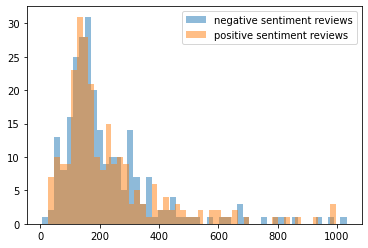

In [47]:
# show histograms of word counts divided per sentiment
from matplotlib import pyplot

x = df[df['sentiment']==0].word_count
y = df[df['sentiment']==1].word_count

pyplot.hist(x, bins=50, alpha=0.5, label='negative sentiment reviews')
pyplot.hist(y, bins=50, alpha=0.5, label='positive sentiment reviews')
pyplot.legend(loc='upper right')
pyplot.show()

In [48]:
# summary of distributions of word counts
print(x.describe())
print(y.describe())

count     250.000000
mean      225.304000
std       167.889365
min         6.000000
25%       128.000000
50%       173.000000
75%       273.250000
max      1032.000000
Name: word_count, dtype: float64
count    250.000000
mean     231.060000
std      176.487301
min       26.000000
25%      125.000000
50%      169.000000
75%      274.000000
max      995.000000
Name: word_count, dtype: float64


In [49]:
# some checks (e.g. word_counts=6 or 1550 or 2498 )
df[df['word_count']==6]

,review,sentiment,0,1,2,3,4,5,6,7,...,87,88,89,90,91,92,93,94,95,word_count
238,primary plot primary direction poor interpreta...,0,1.93245,2.434365,-1.642762,-0.635336,1.754666,0.09242,-0.156321,-0.168393,...,-2.497162,-1.856147,-0.388898,-0.19619,-0.678068,-0.620965,2.937752,0.061259,0.844795,6


In [50]:
# average word length (again, we tokenize by whitespaces)
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['review'].apply(lambda x: avg_word(x.strip()))
df[['review','word_count', 'sentiment', 'avg_word']].head()

,review,word_count,sentiment,avg_word
0,i ve only seen this film once when it was show...,144,1,4.125000
1,disney the film name that once stood for all t...,922,1,4.364425
2,this movie is the only movie to feature a scen...,77,1,4.220779
3,the eternal jew der ewige jude does not have w...,562,0,4.765125
4,this movie is just plain terrible poor john sa...,301,0,3.943522


In [51]:
# distributions of word lengths conditional per sentiment
x = df[df['sentiment']==0].avg_word
y = df[df['sentiment']==1].avg_word
print(x.describe())
print()
print(y.describe())

count    250.000000
mean       4.292849
std        0.365534
min        3.500000
25%        4.079142
50%        4.295587
75%        4.509106
max        7.500000
Name: avg_word, dtype: float64

count    250.000000
mean       4.316774
std        0.340776
min        3.385093
25%        4.099108
50%        4.295241
75%        4.542389
max        5.512195
Name: avg_word, dtype: float64


In [52]:
# some checks (e.g. avg_word>=7)
df[df['avg_word']>=7]

,review,sentiment,0,1,2,3,4,5,6,7,...,88,89,90,91,92,93,94,95,word_count,avg_word
238,primary plot primary direction poor interpreta...,0,1.93245,2.434365,-1.642762,-0.635336,1.754666,0.09242,-0.156321,-0.168393,...,-1.856147,-0.388898,-0.19619,-0.678068,-0.620965,2.937752,0.061259,0.844795,6,7.5


In [53]:
# stop words statistics - stopword from NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['review'].apply(lambda x: len([x for x in x.strip().split() if x in stop]))
df[['review','word_count', 'sentiment', 'avg_word', 'stopwords']].head()

,review,word_count,sentiment,avg_word,stopwords
0,i ve only seen this film once when it was show...,144,1,4.125000,79
1,disney the film name that once stood for all t...,922,1,4.364425,461
2,this movie is the only movie to feature a scen...,77,1,4.220779,32
3,the eternal jew der ewige jude does not have w...,562,0,4.765125,253
4,this movie is just plain terrible poor john sa...,301,0,3.943522,161


In [54]:
# distributions of stop words conditional per sentiment
x = df[df['sentiment']==0].stopwords
y = df[df['sentiment']==1].stopwords
print(x.describe())
print()
print(y.describe())

count    250.00000
mean     110.61600
std       82.60588
min        0.00000
25%       62.00000
50%       85.00000
75%      136.00000
max      523.00000
Name: stopwords, dtype: float64

count    250.000000
mean     113.608000
std       86.026978
min        8.000000
25%       62.000000
50%       87.000000
75%      130.750000
max      491.000000
Name: stopwords, dtype: float64


In [55]:
# some checks (e.g. stopwords==0)
df[df['stopwords']==0]

,review,sentiment,0,1,2,3,4,5,6,7,...,89,90,91,92,93,94,95,word_count,avg_word,stopwords
238,primary plot primary direction poor interpreta...,0,1.93245,2.434365,-1.642762,-0.635336,1.754666,0.09242,-0.156321,-0.168393,...,-0.388898,-0.19619,-0.678068,-0.620965,2.937752,0.061259,0.844795,6,7.5,0


# 5. Machine Learning<a name="ML"></a>

## 5.1. Adaptive boosting (ADA)<a name="ADA"></a>

### 5.1.1. Bag-of-words<a name="ADA_BOW"></a>

In [61]:
# loading Python packages
#########################
import time
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
#调参用的
#https://blog.csdn.net/weixin_41988628/article/details/83098130
#GridSearchCV 网格搜索

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import 
import pandas as pd

path = './toymdb/data_dedandprep.csv'  # insert path to deduplicated and preprocessed data
df = pd.read_csv(path)     

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(400).review
y_train = df.head(400).sentiment

X_test = df.tail(100).review
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)
#定义tfidf函数，目的是将文本转化为tfidf向量，在该模型中是pipeline的第一步

param_grid = {'vect__ngram_range': [(1, 1)],           # choose (1, 2) to compute 2-grams
              'vect__stop_words': [stopwords, None],    #表示使用停用词和不使用停用词两种情况
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],     #max_df用于删除过于频繁出现的术语,也称为“语料库特定的停用词”.例如：
                                                        #max_df = 0.50表示“忽略出现在50％以上文档中的术语”
              'vect__max_features': [None, 400],    #1000改为400                                        
              'clf__n_estimators': [10, 20, 30, 40], #[100, 200, 300, 400]改为[10, 20, 30, 40]
              #该参数表示基分类器提升（循环）次数，默认是50次，这个值过大，模型容易过拟合；值过小，模型容易欠拟合
              'clf__learning_rate': [0.001, 0.01, 0.1] #去掉1.0的值 减少选择数
              }

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )
#pipeline管道机制使用方法：
#流水线的输入为一连串的数据挖掘步骤，其中最后一步必须是估计器（Estimator），可理解成分类器
#前几步是转换器（Transformer）。输入的数据集经过转换器的处理后，输出的结果作为下一步的输入。
#最后，用位于流水线最后一步的估计器对数据进行分类。

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )
#交叉验证参数

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1) 
#第一个参数是estimator，即所使用的分类器
#第二个参数是param_grid，值为字典或者列表，表示需要最优化的参数的取值
#第三个参数是scoring，模型评价标准，这里选择了roc_auc
#第四个参数是cv，交叉验证参数。
#第五个参数是n_jobs，并行线程数，取-1表示跟CPU核数一致


---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400,)
X_test shape check:  (100,)
---------------------
---------------------
---------------------
---------------------


In [62]:
# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))
# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')


KeyboardInterrupt: 

### 5.1.2. Bag-of-POS<a name="ADA_BOP"></a>

跟5.1.1不同的地方在于，5.1.2输入的是data_POStagged.csv数据
即5.1.1用文本数据生成tfidf向量，5.1.2采用词性序生成tfidf向量作为AdaBoost的分类依据
从原理上看，POS数据损失了部分信息

In [63]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_POStagged.csv'  
# insert path to data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(400).text_pos
y_train = df.head(400).sentiment

X_test = df.tail(100).text_pos
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__learning_rate': [0.001, 0.01, 0.1]}

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)                        # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400,)
X_test shape check:  (100,)
---------------------
---------------------
---------------------
---------------------
Running time: 12.423156261444092 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__learning_rate': 0.001, 'clf__n_estimators': 30, 'vect__ngram_range': (1, 1)} 
---------------------
---------------------
---------------------
---------------------
Test AUC: 0.487
Test Accuracy: 0.500
---------------------
---------------------
---------------------
---------------------


### 5.1.3. Embeddings<a name="ADA_E"></a>

和前面两种方法不一样，Embeddings方法用的是3.4.2 中根据en_core_web_sm模型得到的词向量数据，所以在pipline中不需要再对输入数据做处理，直接用AdaBoostClassifier进行拟合即可

In [64]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_dedandprep.csv'  
# insert path to data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(400)    # we use only the 300 embeddings
y_train = df.head(400).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(100)      # we use only the 300 embeddings
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__n_estimators': [10, 20, 30, 40],
              'clf__learning_rate': [0.001, 0.01, 0.1]}

# extended parameter grid (Table 6, Section 6.4.5 in the tutorial)
# param_grid = {'clf__n_estimators': [100, 200, 300, 400, 500, 700, 900, 1000],
#              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

tree = DecisionTreeClassifier(max_depth=5)

pipe = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree))])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='accuracy',
                           cv=cv, 
                           n_jobs=-1)                        # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()

gs_lr_tfidf.fit(X_train, y_train)

end=time.time()
print('Running time: %s Seconds'%(end-start))
# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400, 96)
X_test shape check:  (100, 96)
---------------------
---------------------
---------------------
---------------------
Running time: 13.306761026382446 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__learning_rate': 0.001, 'clf__n_estimators': 10} 
---------------------
---------------------
---------------------
---------------------
Test AUC: 0.438
Test Accuracy: 0.460
---------------------
---------------------
---------------------
---------------------


## 5.2. Random Forests (RF)<a name="RF"></a>

### 5.2.1. Bag-of-words<a name="RF_BOW"></a>

In [65]:
# loading Python packages
#########################

from sklearn.utils import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_dedandprep.csv'  # insert path to deduplicated and preprocessed data
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(400).review
y_train = df.head(400).sentiment

X_test = df.tail(100).review
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],    # for 2-grams:(1, 2)
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 400],                                           
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)       # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400,)
X_test shape check:  (100,)
---------------------
---------------------
---------------------
---------------------
Running time: 96.45190691947937 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 40, 'vect__max_df': 0.5, 'vect__max_features': 400, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['over', "that'll", 'their', 'because', 've', 'other', 'and', 'after', 'all', 'shouldn', "hasn't", "isn't", 'yours', 'mustn', 'd', "should've", 'than', 'have', 'didn', "haven't", 'who', 'themselves', 'further', 'we', 'few', 'on', 'has', "wouldn't", 'above', 'been', "won't", 'an', 'between', 'yourself', 'myself', 'them', 'most', 'then', 'under', 'through', 'here', 'this', "she's", "mustn't", "you'll", 'weren', 'where', 'very', 'if', 'against', 'herself', 'it', 'or', 'its

### 5.2.2. Bag-of-POS<a name="RF_BOP"></a>

In [75]:
# loading Python packages
#########################

from sklearn.utils import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_POStagged.csv'  # insert path to data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(400).text_pos
y_train = df.head(400).sentiment

X_test = df.tail(100).text_pos
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)              # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400,)
X_test shape check:  (100,)
---------------------
---------------------
---------------------
---------------------
Running time: 1.977264165878296 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__max_depth': 5, 'clf__n_estimators': 40, 'vect__ngram_range': (1, 1)} 
---------------------
---------------------
---------------------
---------------------
Test AUC: 0.572
Test Accuracy: 0.550
---------------------
---------------------
---------------------
---------------------


### 5.2.3. Embeddings<a name="RF_E"></a>

In [66]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import 
import pandas as pd

path = './toymdb/data_dedandprep.csv'  # insert path to data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(400)    # we use only the 300 embeddings
y_train = df.head(400).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(100)     # we use only the 300 embeddings
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__max_depth': [1, 5, 10]
             }

# extended parameter grid (Table 6, Section 6.4.5 in the tutorial)
# param_grid = {'clf__n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
#              'clf__max_depth': [1, 5, 10, 20]}

pipe = Pipeline([('clf', RandomForestClassifier())
               ])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)               # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400, 96)
X_test shape check:  (100, 96)
---------------------
---------------------
---------------------
---------------------
Running time: 3.092280149459839 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__max_depth': 1, 'clf__n_estimators': 30} 
---------------------
---------------------
---------------------
---------------------
Test AUC: 0.639
Test Accuracy: 0.590
---------------------
---------------------
---------------------
---------------------


## 5.3. Extreme gradient boosting (XGB)<a name="XGB"></a>

### 5.3.1. Bag-of-words<a name="XGB_BOW"></a>

这个最久，要四分多钟

In [69]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_dedandprep.csv'  # insert path to preprocessed and deduplicated data
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(400).review
y_train = df.head(400).sentiment

X_test = df.tail(100).review
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#如果import失败要先安装，安装代码如下
#import pip
#pip.main(['install', 'xgboost'])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],    # for 2-grams: (1,2)
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 400],                                           
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__learning_rate': [0.001, 0.01, 0.1],
              'clf__max_depth': [1, 5, 10]
              }


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)                 # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400,)
X_test shape check:  (100,)
---------------------
---------------------
---------------------
---------------------


KeyboardInterrupt: 

### 5.3.2. Bag-of-POS<a name="XGB_BOP"></a>

In [70]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_POStagged.csv'  # insert data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(400).review
y_train = df.head(400).sentiment

X_test = df.tail(100).review
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__learning_rate': [0.001, 0.01, 0.1],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]
                    )


# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )


gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)              # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400,)
X_test shape check:  (100,)
---------------------
---------------------
---------------------
---------------------


/Users/Guangyuan/opt/anaconda3/envs/r_keras/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running time: 105.92212080955505 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 40, 'vect__ngram_range': (1, 1)} 
---------------------
---------------------
---------------------
---------------------
Test AUC: 0.770
Test Accuracy: 0.660
---------------------
---------------------
---------------------
---------------------


### 5.3.3. Embeddings<a name="XGB_E"></a>

In [71]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/data_dedandprep.csv'  # insert data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(400)    # we use only the 300 embeddings
y_train = df.head(400).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(100)     # we use only the 300 embeddings
y_test = df.tail(100).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              'clf__n_estimators': [10, 20, 30, 40],
              'clf__learning_rate': [0.001, 0.01, 0.1],
              'clf__max_depth': [1, 5, 10]
              }

pipe = Pipeline([('clf', XGBClassifier())
                ])
                    
# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=-1)        # insert the number of jobs, according to the used machine

# running the grid
###########################################
start=time.time()
gs_lr_tfidf.fit(X_train, y_train)
end=time.time()
print('Running time: %s Seconds'%(end-start))

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (400, 96)
X_test shape check:  (100, 96)
---------------------
---------------------
---------------------
---------------------
[22:59:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running time: 26.01372790336609 Seconds
---------------------
---------------------
---------------------
---------------------
Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 40} 
---------------------
---------------------
---------------------
---------------------
Test AUC: 0.633
Test Accuracy: 0.580
---------------------
---------------------
---------------------
---------------------


/Users/Guangyuan/opt/anaconda3/envs/r_keras/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# 6. Deep Learning<a name="DL"></a>

In [72]:
# to ensure that all keras functionalities work as intended
from __future__ import absolute_import, division, print_function, unicode_literals

In [73]:
# import the data
import pandas as pd
import os
import numpy as np

path = "./toymdb/movie_data_processed.csv" # TODO: update to your path
df_processed = pd.read_csv(path, encoding='utf-8')
df_processed.shape

(500, 201)

## 6.1 Train test split<a name="trainsplit"></a>

In [74]:
# get the number of samples for the training and test datasets
perc_train = 0.8
n_train = round(df_processed.shape[0]*perc_train)
n_test = round(df_processed.shape[0]*(1-perc_train))

print(str(int(perc_train*100))+'/'+str(int(100-perc_train*100))+' train test split:', 
      n_train, '/', n_test)

80/20 train test split: 400 / 100


In [75]:
# create the training and testing datasets
X_train = np.array(df_processed.head(n_train).drop('sentiment', axis=1)) # replace with n_train
y_train = df_processed.head(n_train).sentiment.values

X_test = np.array(df_processed.tail(n_test).drop('sentiment', axis=1)) # replace with n_test
y_test = df_processed.tail(n_test).sentiment.values

print('Training data shape check X, y:', X_train.shape, y_train.shape)
print('Testing data shape check X, y:', X_test.shape, y_test.shape)

Training data shape check X, y: (400, 200) (400,)
Testing data shape check X, y: (100, 200) (100,)


## 6.2 Define the model<a name="modeldef"></a>

In [76]:
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# get the total number of words in vocabulary (+1 for the padding with 0)
vocab_size = df_processed.drop('sentiment', axis=1).values.max() + 1
print('Vocabulary size:', vocab_size-1)

Vocabulary size: 399


### 6.2.1 Shallow LSTM architecture<a name="LSTM1"></a>

In [77]:
# Create a new model
model = tf.keras.Sequential()

# Add an Embedding layer expecting input of the size of the vocabulary, and
# the embedding output dimension
model.add(layers.Embedding(input_dim=vocab_size, output_dim=256)) 

# Add a LSTM layer with 128 internal units
model.add(layers.LSTM(128))

# Add a Dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))

# Add Dense layer as output layer with 1 unit and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

In [78]:
# Create a new model
model = tf.keras.Sequential()

# Add an Embedding layer expecting input of the size of the vocabulary, and
# the embedding output dimension
model.add(layers.Embedding(input_dim=vocab_size, output_dim=256)) 

# Add a GRU layer with 128 internal units
model.add(layers.GRU(128))

# Add a Dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))

# Add Dense layer as output layer with 1 unit and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

### 6.2.3 Deep LSTM architecture<a name="LSTM2"></a>

In [79]:
# Create a new model
model = tf.keras.Sequential()

# Add an Embedding layer expecting input of the size of the vocabulary, and
# the embedding output dimension
model.add(layers.Embedding(input_dim=vocab_size, output_dim=256)) 

# Add a LSTM layer with 128 internal units
# Return sequences so we can stack the the next LSTM layer on top
model.add(layers.LSTM(128, return_sequences=True))

# Add a second LSTM layer
model.add(layers.LSTM(128))

# Add a Dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))

# Add Dense layer as output layer with 1 unit and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

## 6.3 Train the model<a name="trainmodel"></a>

In [80]:
# print the summary of the model we have defined
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         102400    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 431,233
Trainable params: 431,233
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
# compile the model
# we select here the optimizer, loss and metric to be used in training
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [82]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [83]:
# train the model
start=time.time()

history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2,
                    epochs=30, 
                    batch_size=256,
                    callbacks=callbacks,
                    verbose=1)

end=time.time()
print('Running time: %s Seconds'%(end-start))

Epoch 1/30
2/2 [==============================] - 2s 1s/step - loss: 0.6929 - accuracy: 0.5469 - val_loss: 0.6936 - val_accuracy: 0.4750
Epoch 2/30
2/2 [==============================] - 1s 715ms/step - loss: 0.6899 - accuracy: 0.5781 - val_loss: 0.6947 - val_accuracy: 0.4750
Epoch 3/30
2/2 [==============================] - 1s 650ms/step - loss: 0.6849 - accuracy: 0.5469 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 4/30
2/2 [==============================] - 1s 586ms/step - loss: 0.6733 - accuracy: 0.5813 - val_loss: 0.6836 - val_accuracy: 0.5500
Epoch 5/30
2/2 [==============================] - 1s 601ms/step - loss: 0.6410 - accuracy: 0.7000 - val_loss: 0.6688 - val_accuracy: 0.5750
Epoch 6/30
2/2 [==============================] - 1s 621ms/step - loss: 0.5814 - accuracy: 0.7125 - val_loss: 0.6735 - val_accuracy: 0.6125
Epoch 7/30
2/2 [==============================] - 1s 583ms/step - loss: 0.5168 - accuracy: 0.7469 - val_loss: 0.6493 - val_accuracy: 0.5875
Epoch 8/30
2/2 [=======

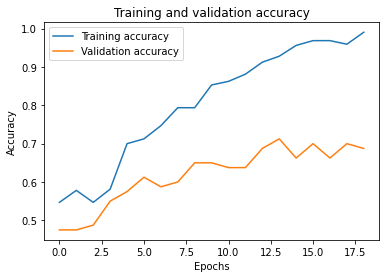

In [84]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

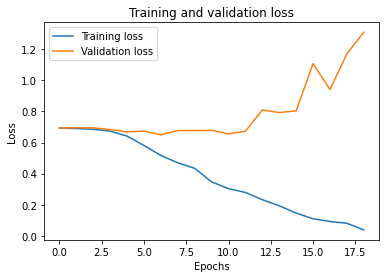

In [85]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 6.4 Evaluate the model on test data<a name="evalmodel"></a>

In [86]:
from sklearn.metrics import roc_auc_score

# evalute model to get accuracy and loss on test data
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)

# calculate AUC on test data
y_pred = model.predict_proba(X_test, batch_size=256)
auc_res = roc_auc_score(y_test, y_pred[:, 0])

print('Test loss:', results[0])
print('Test accuracy:', results[1])
print('Test AUC:', auc_res)

Instructions for updating:
Please use `model.predict()` instead.
Test loss: 1.066556453704834
Test accuracy: 0.6800000071525574
Test AUC: 0.6903044871794872
